# 第7章: 機械学習

本章では、[Stanford Sentiment Treebank (SST)](https://nlp.stanford.edu/sentiment/) データセットを用い、評判分析器（ポジネガ分類器）を構築する。ここでは処理を簡略化するため、[General Language Understanding Evaluation (GLUE)](https://gluebenchmark.com/) ベンチマークで配布されているSSTデータセットを用いる。


## 60. データの入手・整形

GLUEのウェブサイトから[SST-2](https://dl.fbaipublicfiles.com/glue/data/SST-2.zip)データセットを取得せよ。学習データ（`train.tsv`）と検証データ（`dev.tsv`）のぞれぞれについて、ポジティブ (1) とネガティブ (0) の事例数をカウントせよ。

In [5]:
# データセットを取得
! wget -O ./data/SST-2.zip https://dl.fbaipublicfiles.com/glue/data/SST-2.zip 
! unzip -d ./data ./data/SST-2.zip

--2025-04-08 00:40:02--  https://dl.fbaipublicfiles.com/glue/data/SST-2.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 54.239.168.51, 54.239.168.65, 54.239.168.70, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|54.239.168.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7439277 (7.1M) [application/zip]
Saving to: ‘./data/SST-2.zip’

./data/SST-2.zip    100%[===================>]   7.09M  33.0MB/s    in 0.2s    

2025-04-08 00:40:02 (33.0 MB/s) - ‘./data/SST-2.zip’ saved [7439277/7439277]

Archive:  ./data/SST-2.zip
   creating: ./data/SST-2/
  inflating: ./data/SST-2/dev.tsv    
   creating: ./data/SST-2/original/
  inflating: ./data/SST-2/original/README.txt  
  inflating: ./data/SST-2/original/SOStr.txt  
  inflating: ./data/SST-2/original/STree.txt  
  inflating: ./data/SST-2/original/datasetSentences.txt  
  inflating: ./data/SST-2/original/datasetSplit.txt  
  inflating: ./data/SST-2/original/dictionary.txt  
  infla

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

train_path = "./data/SST-2/train.tsv"
dev_path = "./data/SST-2/dev.tsv"
test_path = "./data/SST-2/test.tsv"

# pandas.DataFrameで読み込み
df_train = pd.read_csv(train_path, sep="\t")
df_dev = pd.read_csv(dev_path, sep="\t")
df_test = pd.read_csv(test_path, sep="\t")

df_train.head()

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0


In [2]:
def countPosNeg(df:DataFrame)->tuple[int, int]:
    size = df.groupby("label").size()
    num_pos = size[1]
    num_neg = size[0]
    return (num_pos, num_neg)

num_pos, num_neg = countPosNeg(df_train)
print(f'Train\tpositive: {num_pos}, negative: {num_neg}')
num_pos, num_neg = countPosNeg(df_dev)
print(f'Dev\tpositive: {num_pos:5d}, negative: {num_neg:5d}')

Train	positive: 37569, negative: 29780
Dev	positive:   444, negative:   428


## 61. 特徴ベクトル

Bag of Words (BoW) に基づき、学習データ（`train.tsv`）および検証データ（`dev.tsv`）のテキストを特徴ベクトルに変換したい。ここで、ある事例のテキストの特徴ベクトルは、テキスト中に含まれる単語（スペース区切りのトークン）の出現頻度で構成する。例えば、"too loud , too goofy"というテキストに対応する特徴ベクトルは、以下のような辞書オブジェクトで表現される。

```python
{'too': 2, 'loud': 1, ',': 1, 'goofy': 1}
```

各事例はテキスト、特徴ベクトル、ラベルを格納した辞書オブジェクトでまとめておく。例えば、先ほどの"too loud , too goofy"に対してラベル"0"（ネガティブ）が付与された事例は、以下のオブジェクトで表現される。

```python
{'text': 'too loud , too goofy', 'label': '0', 'feature': {'too': 2, 'loud': 1, ',': 1, 'goofy': 1}}
```

学習データと検証データの各事例を上記のような辞書オブジェクトに変換したうえで、学習データと検証データのそれぞれを、辞書オブジェクトのリストとして表現せよ。さらに、学習データの最初の事例について、正しく特徴ベクトルに変換できたか、目視で確認せよ。

In [30]:
from collections import defaultdict
from tqdm import tqdm

def BoW(df:DataFrame)->list[dict[str, str | dict[str, int]]]:
    def BoW_feature(text:str)->dict[str, int]:
        feature = defaultdict(int)
        words = text.split()
        for word in words:
            feature[word] += 1
        return feature

    data = list()
    for index, row in df.iterrows():
        text = row["sentence"]
        label = row["label"]
        feature = BoW_feature(text)
        data.append({"text":text, "label":label, "feature":feature})
    return data

train_BoW = BoW(df_train)
dev_BoW = BoW(df_dev)

print(train_BoW[0])
print(dev_BoW[0])

def createDict(BoWs: list[dict[str, str | dict[str, int]]])->list[str]:
    """
    訓練データから辞書を作成
    """
    l = list()
    d = defaultdict(int)
    for Bow in BoWs:
        for word in Bow["feature"]:
            d[word] += 1
    for key in d:
        # 出現回数が10回以上の単語を辞書に追加
        if d[key] > 9:
            l.append(key)
    return l

word_dict = createDict(train_BoW)
lenFeature = len(word_dict)
print("length word dict:",len(word_dict))

def loadData(BoWs: list[dict[str, str | dict[str, int]]]) -> list[dict[str, str | list[int]]]:
    def getFeature(feature_pre: dict[str, int])->list[int]:
        v = [0 for _ in range(lenFeature)]
        for word in feature_pre: 
            if(word in word_dict):
                v[word_dict.index(word)] += 1
        return v
    
    data = []
    for BoW in tqdm(BoWs):
        BoW["feature"] = getFeature(BoW["feature"])
        data.append(BoW)
    return data

train = loadData(train_BoW)
dev = loadData(dev_BoW)
print(train[0])



{'text': 'hide new secretions from the parental units ', 'label': 0, 'feature': defaultdict(<class 'int'>, {'hide': 1, 'new': 1, 'secretions': 1, 'from': 1, 'the': 1, 'parental': 1, 'units': 1})}
{'text': "it 's a charming and often affecting journey . ", 'label': 1, 'feature': defaultdict(<class 'int'>, {'it': 1, "'s": 1, 'a': 1, 'charming': 1, 'and': 1, 'often': 1, 'affecting': 1, 'journey': 1, '.': 1})}
length word dict: 6541


100%|██████████| 872/872 [00:00<00:00, 1703.73it/s]

{'text': 'hide new secretions from the parental units ', 'label': 0, 'feature': [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## 62. 学習

61で構築した学習データの特徴ベクトルを用いて、ロジスティック回帰モデルを学習せよ。

In [31]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
X = [item["feature"] for item in train]
y = [item["label"] for item in train]
model.fit(X, y)

LogisticRegression()

## 63. 予測

学習したロジスティック回帰モデルを用い、検証データの先頭の事例のラベル（ポジネガ）を予測せよ。また、予測されたラベルが検証データで付与されていたラベルと一致しているか、確認せよ。

In [33]:
feature = dev[0]["feature"]
text = dev[0]["text"]
print(f"text: {text}")
label = "positive" if dev[0]["label"] == 1 else "negative"

pred = model.predict([feature])[0]
pred_label = "positive" if pred == 1 else "negative"
print(f"pred: {pred_label}")
print(f"gold: {label}")

text: it 's a charming and often affecting journey . 
pred: positive
gold: positive


## 64. 予測

学習したロジスティック回帰モデルを用い、検証データの先頭の事例を各ラベル（ポジネガ）に分類するときの条件付確率（尤度）を求めよ。

In [34]:
feature = dev[0]["feature"]
text = dev[0]["text"]
print(f"text: {text}, label: {dev[0]['label']}")

pred_proba = model.predict_proba([feature])[0]
print(pred_proba)

text: it 's a charming and often affecting journey . , label: 1
[0.0033249 0.9966751]


## 65. 正解率の計測

学習したロジスティック回帰モデルの正解率を、学習データおよび検証データ上で計測せよ。

In [37]:
from sklearn.metrics import accuracy_score

pred = model.predict(X)
print(f"train:\taccuracy={accuracy_score(y, pred):.4f}")

X_dev = [item["feature"] for item in dev]
y_dev = [item["label"] for item in dev]

pred = model.predict(X_dev)
print(f"dev:\taccuracy={accuracy_score(y_dev, pred):.4f}")

train:	accuracy=0.9023
dev:	accuracy=0.8050


## 66. テキストのポジネガの予測

与えられたテキストのポジネガを予測するプログラムを実装せよ。例えば、テキストとして"the worst movie I 've ever seen"を与え、ロジスティック回帰モデルの予測結果を確認せよ。


In [35]:
def predict_posneg(model:LogisticRegression, text:str)->int:
    def BoW_feature(text:str)->dict[str, int]:
        feature = defaultdict(int)
        words = text.split()
        for word in words:
            feature[word] += 1
        return feature
    
    def getFeature(feature_pre: dict[str, int])->list[int]:
        v = [0 for _ in range(lenFeature)]
        for word in feature_pre: 
            if(word in word_dict):
                v[word_dict.index(word)] += 1
        return v
    
    x = getFeature(BoW_feature(text))
    res = model.predict([x])[0]
    return "positive" if res == 1 else "negative"

print(predict_posneg(model, "the worst movie I 've ever seen"))

negative


## 67. 混同行列の作成

学習したロジスティック回帰モデルの検証データにおける混同行列（confusion matrix）を求めよ。

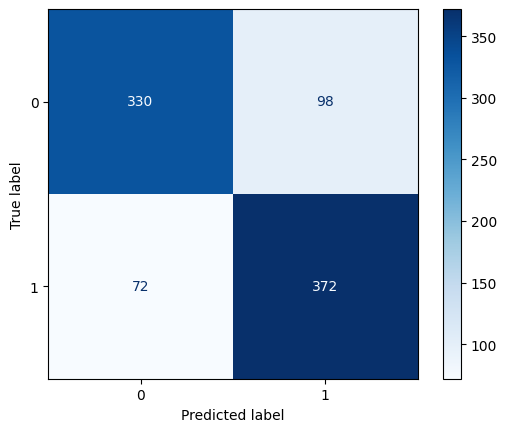

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_dev, pred)
fig = ConfusionMatrixDisplay(cm)
fig.plot(cmap=plt.cm.Blues)
plt.show()

## 68. 適合率、再現率、F1スコアの計測

ロジスティック回帰モデルの適合率、再現率、F1スコアを、検証データ上で計測せよ。

In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_dev, pred))

              precision    recall  f1-score   support

           0       0.82      0.77      0.80       428
           1       0.79      0.84      0.81       444

    accuracy                           0.81       872
   macro avg       0.81      0.80      0.80       872
weighted avg       0.81      0.81      0.80       872



## 68. 特徴量の重みの確認

学習したロジスティック回帰モデルの中で、重みの高い特徴量トップ20と、重みの低い特徴量トップ20を確認せよ。

In [40]:
top20 = [i for i, _ in sorted(enumerate(model.coef_[0]), key=lambda x: x[1], reverse=True)[:20]]
print("top20:")
for index, i in enumerate(top20):
    print(index + 1, word_dict[i])

print("\nlast20:")
last20 = [i for i, _ in sorted(enumerate(model.coef_[0]), key=lambda x: x[1], reverse=False)[:20]]
for index, i in enumerate(last20):
    print(index + 1, word_dict[i])

top20:
1 refreshing
2 remarkable
3 powerful
4 hilarious
5 beautiful
6 treat
7 likable
8 miracle
9 terrific
10 charmer
11 fascinating
12 prose
13 engrossing
14 appealing
15 enjoyable
16 wonderful
17 visuals
18 solid
19 impressive
20 charming

last20:
1 lacking
2 worst
3 lacks
4 devoid
5 mess
6 failure
7 stupid
8 bored
9 bore
10 flat
11 waste
12 squanders
13 loses
14 depressing
15 lack
16 repetitive
17 none
18 lousy
19 elsewhere
20 pointless


## 69. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき、正則化の係数（ハイパーパラメータ）を調整することで、学習時の適合度合いを制御できる。正則化の係数を変化させながらロジスティック回帰モデルを学習し、検証データ上の正解率を求めよ。実験の結果は、正則化パラメータを横軸、正解率を縦軸としたグラフにまとめよ。